In [1]:
from glob import glob
import os.path
from os.path import join
import sys

from aicsimageio import AICSImage
import matplotlib.pyplot as plt
import napari as na
import numpy as np
import pandas as pd

sys.path.append(r"C:\Users\djfoust\Documents\Python Scripts\biteen_utilities")
import biteen_utilities as bu

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [2]:
def particle_mobility(folder: str, D_app_file: str = 'D_app_data.npy'):
    """
    data : dict    
    """
    data_file = join(folder, D_app_file)
    D_app_data = np.load(data_file, allow_pickle=True)

    bin_edges = np.linspace(0,100,21)

    output = {}
    locs_files = D_app_data.item()['D_app'].keys()
    for dkey in locs_files:
        D_app = D_app_data.item()['D_app'][dkey]
        ids = D_app_data.item()['ids'][dkey]

        track_file = join(folder, os.path.basename(dkey))
        track_data = pd.read_csv(track_file, index_col=0)

        track_data = bu.filter_by_nlocs(track_data, min_locs=20, track_col='n')
        track_data['D_app'] = 0
        for i in np.unique(ids):
            track_data.loc[track_data['n']==i, 'D_app'] = np.pad(D_app[ids==i], pad_width=(9,10), mode='edge')

        track_data['mobile'] = track_data['D_app'] >= 0.0003

        particle_data = pd.DataFrame(index=np.arange(len(np.unique(track_data['n']))))
        for i, tid in enumerate(np.unique(ids)):
            length = (track_data['n']==tid).sum()
            mobility = track_data.loc[track_data['n']==tid, 'mobile'].mean()*100
            particle_data.loc[i, ['id', 'length', '% mobile']] = [tid, length, mobility]

        
        h_mob, _ = np.histogram(particle_data['% mobile'],
                                bins=bin_edges)
        
        h_mob_w, _ = np.histogram(particle_data['% mobile'],
                                  bins=bin_edges,
                                  weights=particle_data['length'])

        h_mob_norm = h_mob / h_mob.sum()
        h_mob_w_norm = h_mob_w / h_mob_w.sum()

        okey = os.path.basename(dkey)
        output[okey] = {}
        output[okey]['track_data'] = track_data
        output[okey]['h_mob'] = h_mob
        output[okey]['h_mob_w'] = h_mob_w
        output[okey]['h_mob_norm'] = h_mob_norm
        output[okey]['h_mob_w_norm'] = h_mob_w_norm

    return output

In [3]:
strains = ('DK1906', 'DK4347', 'DK479', 'DK5081')

folders = [
    r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR1\2023-06-29__rois_g-r_radsym_cons",
    r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR2\2023-06-29__rois_g-r_radsym_cons",
    r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR3\2023-06-29__rois_g-r_radsym_cons",
]

for folder in folders:
    output = particle_mobility(folder=folder)
    mobility_results = pd.read_csv(
        join(folder, 'mobility results.csv'),
        index_col=0
        )
    
    movies = mobility_results['movie']

    for okey, odata in output.items():
        f_mobile_particles = 1 - odata['h_mob_norm'][0:2].sum()
        f_mobile_particles_weighted = 1 - odata['h_mob_w_norm'][0:2].sum()

        for movie in movies:
            if okey in movie:
                mobility_results.loc[mobility_results['movie']==movie, 'f_mobile_particles'] = f_mobile_particles
                mobility_results.loc[mobility_results['movie']==movie, 'f_mobile_particles_weighted'] = f_mobile_particles_weighted

    mobility_results.to_csv(join(folder, 'mobility results.csv'))

C:\Users\djfoust\AppData\Local\Temp\1\ipykernel_3852\667571451.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.32993796e-05 2.32993796e-05 2.32993796e-05 2.32993796e-05
 2.32993796e-05 2.32993796e-05 2.32993796e-05 2.32993796e-05
 2.32993796e-05 2.32993796e-05 2.32993796e-05 2.32993796e-05
 2.32993796e-05 2.32993796e-05 2.32993796e-05 2.32993796e-05
 2.32993796e-05 2.32993796e-05 2.32993796e-05 2.32993796e-05]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  track_data.loc[track_data['n']==i, 'D_app'] = np.pad(D_app[ids==i], pad_width=(9,10), mode='edge')
C:\Users\djfoust\AppData\Local\Temp\1\ipykernel_3852\667571451.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.03130368e-04  1.03130368e-04  1.03130368e-04  1.03130368e-04
  1.03130368e-04  1.03130368e-04  1.03130368e-04  1.03130368e-04

In [4]:
strains = ('DK1906', 'DK4347', 'DK479', 'DK5081')
strain_results_dict = {k: [] for k in strains}

for folder in folders:
    mobility_results = pd.read_csv(join(folder, 'mobility results.csv'))
    rep = int(folder.split('BR')[1][0])
    # cond = folder.split('Condition')[2].split('\\')[0].split(' ')[-1]
    mobility_results['Rep'] = rep
    # mobility_results['Condition'] = cond

    for strain in strains:
        strain_results = mobility_results[mobility_results['strain']==strain].copy()
        strain_results_dict[strain].append(strain_results)


with pd.ExcelWriter(
    r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\mobility results summary.xlsx", 
    mode='w'
    ) as writer:
    for k, data in strain_results_dict.items():
        data_concat = pd.concat(data, ignore_index=True)
        data_concat.to_excel(writer, sheet_name=k)

In [3]:
folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Condition Changes\Condition 1 ONs\Bio Rep 1\2023-06-29__rois_g-r_radsym_cons"

output = particle_mobility(folder=folder)

C:\Users\djfoust\AppData\Local\Temp\1\ipykernel_7148\667571451.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.47733173e-05  1.47733173e-05  1.47733173e-05  1.47733173e-05
  1.47733173e-05  1.47733173e-05  1.47733173e-05  1.47733173e-05
  1.47733173e-05  1.47733173e-05  6.40984381e-05  2.70693543e-05
  1.12926751e-04  8.40355043e-05  8.79820687e-05 -3.16523080e-06
  8.24233902e-06  1.31713412e-05  4.17304895e-06 -1.32185759e-05
 -1.62855785e-05 -5.51808885e-06 -3.87962761e-06  1.90863187e-05
 -1.04049613e-07  3.29387782e-05 -3.20066517e-06 -2.36495342e-06
  1.41118291e-05  5.28334147e-06  5.48173065e-08  1.32802533e-05
 -4.01321404e-06  2.73115443e-06  1.30437220e-05  2.95616812e-06
  2.20774948e-06  1.54759683e-05  2.69889459e-05  4.43726211e-05
  6.69575963e-05  1.36326200e-04  1.12505349e-04  1.43120193e-04
  1.56579855e-04  2.63633345e-04  2.16442552e-04  1.97671864e-04
  2.80395651e-04  2.10683448e-04

In [5]:
output.keys()

dict_keys(['DB841_1525fG_85T_250ms1m_007.locs', 'DB841_1525fG_85T_250ms1m_008.locs', 'DB841_1525fG_85T_250ms1m_009.locs', 'DB841_1525fG_85T_250ms1m_010.locs', 'DB843_1525fG_85T_250ms1m_011.locs', 'DB843_1525fG_85T_250ms1m_012.locs', 'DB843_1525fG_85T_250ms1m_013.locs', 'DB843_1525fG_85T_250ms1m_014.locs', 'DB843_1525fG_85T_250ms1m_015.locs', 'DK5082_1525fG_85T_250ms1m_002.locs', 'DK5082_1525fG_85T_250ms1m_003.locs', 'DK5082_1525fG_85T_250ms1m_004.locs'])

# load calculated D_app

In [4]:
folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Strains Bio Rep 3\2023-06-29__rois_g-r_radsym_cons"
fname = r"D_app_data.npy"

data = np.load(join(folder, fname), allow_pickle=True)

# Find D_app and tracks for a particular movie

In [5]:
locs_files = data.item()['D_app'].keys()

# target_movie = r"DK479_1525gfst_250ms1min_003"
target_movie = r"DK1906_1525gfst_250ms1min_003"

for lf in locs_files:
    if target_movie in lf:
        D_app = data.item()['D_app'][lf]
        ids = data.item()['ids'][lf]

track_files = glob(join(folder, "*.locs"))
for tf in track_files:
    if target_movie in tf:
        track_data = pd.read_csv(tf)

# Fill D_app for unassigned locs (at ends), assign mobile or immobile
* threshold is 0.0003 um^2/s

In [6]:
track_data = bu.filter_by_nlocs(track_data, min_locs=20, track_col='n')
track_data['D_app'] = 0
for i in np.unique(ids):
    track_data.loc[track_data['n']==i, 'D_app'] = np.pad(D_app[ids==i], pad_width=(9,10), mode='edge')

track_data['mobile'] = track_data['D_app'] >= 0.0003

C:\Users\djfoust\AppData\Local\Temp\1\ipykernel_18196\2721141395.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2.89108034e-06 -2.89108034e-06 -2.89108034e-06 -2.89108034e-06
 -2.89108034e-06 -2.89108034e-06 -2.89108034e-06 -2.89108034e-06
 -2.89108034e-06 -2.89108034e-06 -9.47297459e-08  1.30603153e-06
  8.21543159e-06  4.28560296e-06 -8.11947135e-06 -4.37267360e-06
 -4.56111599e-06 -2.19097995e-06 -1.79055055e-06 -2.87159955e-06
 -4.53500690e-06  7.91725396e-06  6.86835262e-06  9.41862379e-06
  1.25966147e-05  1.47579152e-05  7.48039656e-06  1.18473041e-05
  8.03825727e-06 -6.18435231e-07 -6.18435231e-07 -6.18435231e-07
 -6.18435231e-07 -6.18435231e-07 -6.18435231e-07 -6.18435231e-07
 -6.18435231e-07 -6.18435231e-07 -6.18435231e-07 -6.18435231e-07]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  track_data.loc[track_data['n']==i, 'D_app'] = np.pad(D_app[ids==i], pa

# For each track, calc % of time mobile

In [7]:
particle_data = pd.DataFrame(index=np.arange(len(np.unique(ids))))

for i, tid in enumerate(np.unique(ids)):
    # print(tid, track_data.loc[track_data['n']==tid, 'mobile'].mean()*100)
    # particle_data.loc[i,'id'] = tid 
    length = (track_data['n']==tid).sum()
    mobility = track_data.loc[track_data['n']==tid, 'mobile'].mean()*100
    particle_data.loc[i,['id', 'length', '% mobile']] = [tid, length, mobility]

In [8]:
bin_edges = np.linspace(0,100,11)
h_mob, _ = np.histogram(particle_data['% mobile'], bins=bin_edges)
h_mob_w, _ = np.histogram(particle_data['% mobile'], bins=bin_edges, weights=particle_data['length'])

h_mob_norm = h_mob / h_mob.sum()
h_mob_w_norm = h_mob_w / h_mob_w.sum()

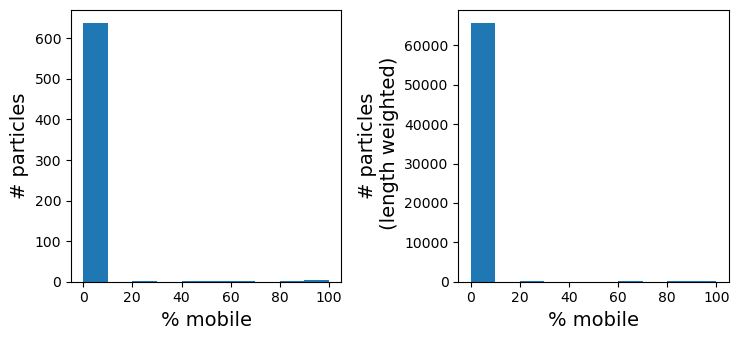

In [9]:
fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))

ax[0].bar(x=bin_edges[:-1], height=h_mob, width=bin_edges[1]-bin_edges[0], align='edge')
ax[0].set_xlabel('% mobile', fontsize=14)
ax[0].set_ylabel('# particles', fontsize=14)

ax[1].bar(x=bin_edges[:-1], height=h_mob_w, width=bin_edges[1]-bin_edges[0], align='edge')
ax[1].set_xlabel('% mobile', fontsize=14)
ax[1].set_ylabel('# particles\n (length weighted)', fontsize=14)

plt.tight_layout()

In [10]:
import matplotlib.colors as mcolors

In [11]:
h_colors = [mcolors.XKCD_COLORS['xkcd:hot magenta']] + 19*[mcolors.XKCD_COLORS['xkcd:green']]

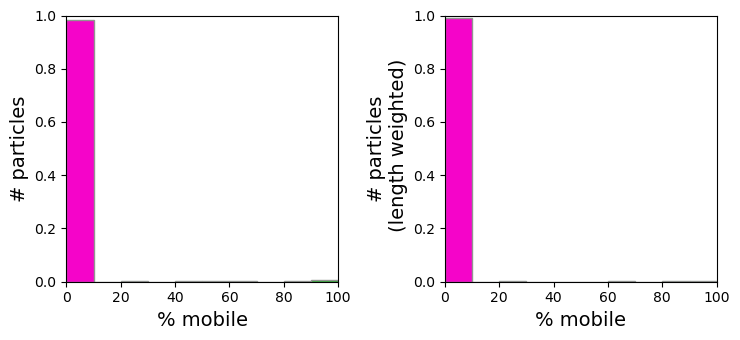

In [12]:
fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))

ax[0].bar(x=bin_edges[:-1],
          height=h_mob_norm,
          width=bin_edges[1]-bin_edges[0],
          align='edge',
          edgecolor='xkcd:grey',
        #   color='xkcd:hot magenta')
          color=h_colors)
ax[0].set_xlabel('% mobile', fontsize=14)
ax[0].set_ylabel('# particles', fontsize=14)
ax[0].set_xlim([0,100])
ax[0].set_ylim([0,1])

ax[1].bar(x=bin_edges[:-1],
          height=h_mob_w_norm,
          width=bin_edges[1]-bin_edges[0],
          align='edge',
          edgecolor='xkcd:grey',
          color=h_colors)
ax[1].set_xlabel('% mobile', fontsize=14)
ax[1].set_ylabel('# particles\n (length weighted)', fontsize=14)
ax[1].set_xlim([0,100])
ax[1].set_ylim([0,1])

plt.tight_layout()

# do for all datasets

In [17]:
def particle_mobility(folder: str, D_app_file: str = 'D_app_data.npy'):
    """
    data : dict    
    """
    data_file = join(folder, D_app_file)
    D_app_data = np.load(data_file, allow_pickle=True)

    bin_edges = np.linspace(0,100,21)

    output = {}
    locs_files = D_app_data.item()['D_app'].keys()
    for dkey in locs_files:
        D_app = D_app_data.item()['D_app'][dkey]
        ids = D_app_data.item()['ids'][dkey]

        track_file = join(folder, os.path.basename(dkey))
        track_data = pd.read_csv(track_file, index_col=0)

        track_data = bu.filter_by_nlocs(track_data, min_locs=20, track_col='n')
        track_data['D_app'] = 0
        for i in np.unique(ids):
            track_data.loc[track_data['n']==i, 'D_app'] = np.pad(D_app[ids==i], pad_width=(9,10), mode='edge')

        track_data['mobile'] = track_data['D_app'] >= 0.0003

        particle_data = pd.DataFrame(index=np.arange(len(np.unique(track_data['n']))))
        for i, tid in enumerate(np.unique(ids)):
            length = (track_data['n']==tid).sum()
            mobility = track_data.loc[track_data['n']==tid, 'mobile'].mean()*100
            particle_data.loc[i, ['id', 'length', '% mobile']] = [tid, length, mobility]

        
        h_mob, _ = np.histogram(particle_data['% mobile'],
                                bins=bin_edges)
        
        h_mob_w, _ = np.histogram(particle_data['% mobile'],
                                  bins=bin_edges,
                                  weights=particle_data['length'])

        h_mob_norm = h_mob / h_mob.sum()
        h_mob_w_norm = h_mob_w / h_mob_w.sum()

        okey = os.path.basename(dkey)
        output[okey] = {}
        output[okey]['track_data'] = track_data
        output[okey]['h_mob'] = h_mob
        output[okey]['h_mob_w'] = h_mob_w
        output[okey]['h_mob_norm'] = h_mob_norm
        output[okey]['h_mob_w_norm'] = h_mob_w_norm

    return output

In [27]:
folder1 = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Strains Bio Rep 1\2023-06-29__rois_g-r_radsym_cons'
# output1 = particle_mobility(folder=folder)

for okey, odata in output1.items():
    strain = okey.split('_')[0]
    summary_sheet = summary_data[strain]

    f_mobile_particles = odata['h_mob_norm'][0:2].sum()
    f_mobile_particles_weighted = odata['h_mob_w_norm'][0:2].sum()

    for movie_name in summary_sheet['movie']:
        if okey in movie_name:
            summary_sheet.loc[summary_sheet['movie']==movie_name, 'f_mobile_particles'] = f_mobile_particles
            summary_sheet.loc[summary_sheet['movie']==movie_name, 'f_mobile_particles_weighted'] = f_mobile_particles_weighted


In [30]:
strains = ['DK1906', 'DK5082', 'DK5081', 'DK5268', 'DK5083', 'DK5084', 'DK4892', 'DK479', 'DK9057', 'DK2118', 'DK8583',
                   'DB841',
                   'DB842', 'DB843', 'DB873', 'DB897', 
                   'DK4347']

In [34]:
folders = [
    # r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Strains Bio Rep 1\2023-06-29__rois_g-r_radsym_cons',
    # r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Strains Bio Rep 2\2023-06-29__rois_g-r_radsym_cons',
    # r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Strains Bio Rep 3\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\DB841 - 3 replicates\BR1\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\DB841 - 3 replicates\BR2\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\DB841 - 3 replicates\BR3\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\FliF Truncations and Mot Rep 1\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\20230911_FliFMotRep2\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\FliFTrunc Mot Rep 3\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Missing from Bio Rep 3 Caroline Dunn\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\DK5083 from Bio Rep 2\2023-06-29__rois_g-r_radsym_cons',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\20230705_repeat_DK479\2023-06-29__rois_g-r_radsym_cons'
]

for folder in folders:
    output = particle_mobility(folder=folder)

    for okey, odata in output.items():
        strain = okey.split('_')[0]
        if strain not in strains:
            for target_strain in strains:
                if target_strain in strain:
                    strain = target_strain

        summary_sheet = summary_data[strain]

        f_mobile_particles = odata['h_mob_norm'][0:2].sum()
        f_mobile_particles_weighted = odata['h_mob_w_norm'][0:2].sum()

        for movie_name in summary_sheet['movie']:
            if okey in movie_name:
                summary_sheet.loc[summary_sheet['movie']==movie_name, 'f_mobile_particles'] = f_mobile_particles
                summary_sheet.loc[summary_sheet['movie']==movie_name, 'f_mobile_particles_weighted'] = f_mobile_particles_weighted

C:\Users\djfoust\AppData\Local\Temp\1\ipykernel_18240\667571451.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.31461928e-05  1.31461928e-05  1.31461928e-05  1.31461928e-05
  1.31461928e-05  1.31461928e-05  1.31461928e-05  1.31461928e-05
  1.31461928e-05  1.31461928e-05  5.05647900e-05  2.04502450e-05
  6.83333745e-05  6.04258683e-05  8.50055011e-05  8.14649784e-05
  5.85878106e-05  7.03046737e-05  4.64986986e-05  9.14621324e-05
  2.49515422e-05  1.16256615e-05 -1.40372298e-05 -3.36301187e-05
 -3.68732280e-05  6.95296650e-06  1.03276456e-05 -1.02836553e-05
 -7.55920117e-06 -5.62039525e-06 -1.01805157e-05 -2.90512884e-06
  5.78955703e-06  2.07296928e-05 -2.93485223e-05 -3.15775356e-05
 -1.59974507e-05 -1.52340235e-05 -8.91124559e-06  2.13037761e-05
  1.87599607e-05  2.67238703e-05  5.03206333e-05  4.70490461e-05
  6.09325201e-05  7.05846961e-05  1.52988650e-04  1.07995696e-04
  5.43165822e-05  1.09905001e-0

In [83]:
summary_copy = summary_data.copy()

for k in strains:
    summary_copy[k]['f_mobile_particles_weighted'] = 1 - summary_copy[k]['f_mobile_particles_weighted']
    summary_copy[k]['f_mobile_particles'] = 1 - summary_copy[k]['f_mobile_particles']

    # df['f_mobile_particles_weighted'] = 1 - df['f_mobile_particles_weighted']
    # df['f_mobile_particles'] = 1 - df['f_mobile_particles']

In [84]:
with pd.ExcelWriter(join(summary_folder, r"bb mutants all mobility estimates with particles4.xlsx")) as writer:
    for k, df in summary_copy.items():
        # df['f_mobile_particles_weighted'] = 1 - df['f_mobile_particles_weighted']
        # df['f_mobile_particles'] = 1 - df['f_mobile_particles']
        df.to_excel(writer, sheet_name=k)

In [65]:
all_mobility_data = [summary_data[strain] for strain in strains]
all_mobility_data = pd.concat(all_mobility_data, axis=0, ignore_index=True)

In [66]:
all_mobility_data['f_mobile_particles_weighted'] = 1 - all_mobility_data['f_mobile_particles_weighted']
all_mobility_data['f_mobile_particles'] = 1 - all_mobility_data['f_mobile_particles']

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\djfoust\Anaconda3\envs\napari-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\djfoust\Anaconda3\envs\napari-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\djfoust\Anaconda3\envs\napari-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\djfoust\Anaconda3\envs\napari-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

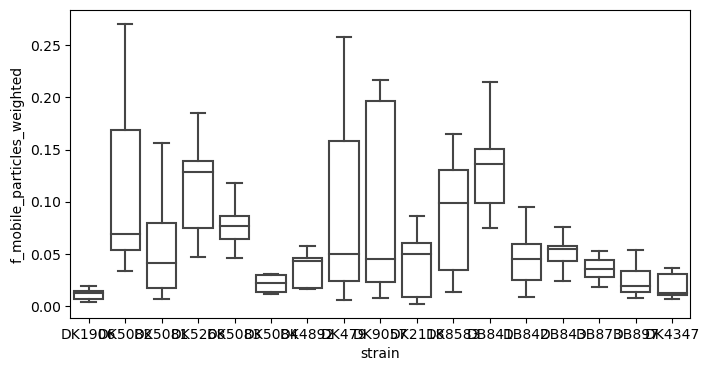

In [71]:
boxprops = {'facecolor': 4*[0]}

pal = sns.color_palette('rocket', n_colors=3)

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=all_mobility_data, x='strain', y='f_mobile_particles_weighted', showfliers=False, boxprops=boxprops, order=strains)
# sns.stripplot(data=all_mobility_data, x='strain', y='f_mobile_particles_weighted', hue='rep', order=strains,
#                 palette=pal)
sns.stripplot(data=all_mobility_data, x='strain', y='f_mobile_particles_weighted', hue='rep', order=strains,
                palette=pal)
plt.xticks(rotation='vertical')
ax.set_yscale('log')
ax.set_xlim([-1,17])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.ylabel('% Mobile', fontsize=16)
plt.xlabel('Strain', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# plt.savefig(join(r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants', '% mobile all bio replicates 2023-10-12 update.png'),
#            dpi=600,
#            transparent=True,
#            bbox_inches='tight')
;
;

In [25]:
summary_folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants"
summary_file = r"bb mutants all mobility estimates.xlsx"

summary_data = pd.read_excel(join(summary_folder, summary_file),
                             index_col=0,
                             sheet_name=None)

In [24]:
strain = list(output.keys())[0].split('_')[0]
summary_data[strain]['movie']

[list(output.keys())[0] in movie_name for movie_name in summary_data[strain]['movie']]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False]

In [76]:
for movie, data in output.items():
    print(movie, '\t',
          data['h_mob_norm'][0:2].sum(), '\t', 
          data['h_mob_w_norm'][0:2].sum())

DK1906_1525gfst_250ms1min_001.locs 	 0.9659318637274549 	 0.9806122839955553
DK1906_1525gfst_250ms1min_002.locs 	 0.9725829725829727 	 0.9871977442966592
DK1906_1525gfst_250ms1min_003.locs 	 0.9815384615384616 	 0.9904682904758314
DK2118_1525gfst_250ms1min_001.locs 	 0.8930131004366813 	 0.9140941889757056
DK2118_1525gfst_250ms1min_002.locs 	 0.8923187365398421 	 0.9252855765061894
DK2118_1525gfst_250ms1min_003.locs 	 0.9214814814814815 	 0.9395306698879079
DK4347_1525fg_250ms1min_005.locs 	 0.9868852459016394 	 0.9936295054484493
DK479_1525gfst_250ms1min_001.locs 	 0.8120104438642298 	 0.8163855234695561
DK479_1525gfst_250ms1min_002.locs 	 0.8169934640522876 	 0.7817817817817818
DK479_1525gfst_250ms1min_003.locs 	 0.7493150684931508 	 0.7422067515638193
DK4892_1525fg_250ms1min_001.locs 	 0.9642857142857143 	 0.9829849691500638
DK4892_1525fg_250ms1min_002.locs 	 0.9773584905660377 	 0.9838545862081043
DK4892_1525fg_250ms1min_003.locs 	 0.9695238095238095 	 0.9814545706179504
DK5081_152

In [67]:
list(output.keys())[0]

'DK1906_1525gfst_250ms1min_001.locs'

In [66]:
output[list(output.keys())[0]]

{'track_data':        index          y          x           I0          bg  error_flag  \
 0          0   6.273061   0.298992  1042.375000  170.375000        True   
 1          2  11.766786   0.412571   750.333333  156.416667        True   
 2          7  10.651753   0.550884   453.833333  158.833333        True   
 3          9   7.573258   0.873741  1116.000000  174.416667        True   
 4         11  11.270095   1.209515   571.000000  154.500000        True   
 ...      ...        ...        ...          ...         ...         ...   
 52193  77846  20.546548  39.668125   519.333333  132.666667        True   
 52194  77847  22.310191  39.701055   595.000000  141.750000        True   
 52195  77848   3.854271  39.866981   711.000000  143.750000        True   
 52196  77850   1.574295  39.958614   709.458333  147.708333        True   
 52197  77851  27.284596  39.981624   708.916667  134.916667        True   
 
               snr  y_detect  x_detect  frame     t     n         D_app 

In [51]:
data.item()['D_app'].keys()

dict_keys(['E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 3\\2023-06-29__rois_g-r_radsym_cons\\DK1906_1525gfst_250ms1min_001.locs', 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 3\\2023-06-29__rois_g-r_radsym_cons\\DK1906_1525gfst_250ms1min_002.locs', 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 3\\2023-06-29__rois_g-r_radsym_cons\\DK1906_1525gfst_250ms1min_003.locs', 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 3\\2023-06-29__rois_g-r_radsym_cons\\DK2118_1525gfst_250ms1min_001.locs', 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 3\\2023-06-29__rois_g-r_radsym_cons\\DK2118_1525gfst_250ms1min_002.locs', 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 3\\2023

In [17]:
particle_data

,id,length,% mobile
0,0.0,23.0,52.173913
1,3.0,241.0,0.000000
2,4.0,53.0,0.000000
3,7.0,185.0,0.000000
4,8.0,241.0,35.684647
...,...,...,...
725,10742.0,21.0,100.000000
726,10747.0,20.0,0.000000
727,10773.0,20.0,0.000000
728,10779.0,20.0,0.000000
